In [1]:
using FactNSF
using SparseArrays
using Random
using LinearAlgebra
using Plots
# using Profile
# using StatProfilerHTML
# using JLD

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


In [2]:
pyplot()

Plots.PyPlotBackend()

In [5]:
function invsigmat(A::Matrix{Float64};atol=1e-15)::Matrix{Float64}
    F = svd(A)
    S = 1.0./F.S
    S[length(S)] = 0.
    return F.V*diagm(S)*F.U'
end

invsigmat (generic function with 1 method)

In [6]:
function invsqrt(A::CanTenDec,atol::Float64;max_iter::Int=200)::CanTenDec
    # Compute norm of A
    Anorm = maximum(sum(A.sig[j]*kron(diag(A.u[j]),diag(A.v[j])) for j in 1:A.rank))

    # Get initial guess
#     kmin = findmin(A.sig[1:A.rank])[2]
#     X0 = CanTenDec(A.size,1,1,
#         [sqrt(Anorm/A.sig[kmin])],
#         [spdiagm(0=>1.0./sqrt.(diag(A.u[kmin])))],
#         [spdiagm(0=>1.0./sqrt.(diag(A.v[kmin])))])
    
#     X0 = CanTenDec(A.size,1,1,
#         [1.0],
#         [spdiagm(0=>Random.rand(A.size))],
#         [spdiagm(0=>Random.rand(A.size))])
    
    X0 = CanTenDec(A.size,1,1,
        [1.0],
        [spdiagm(0=>ones(A.size))],
        [spdiagm(0=>ones(A.size))])
    
#     X0 = CanTenDec(A.size,A.rank,A.rank,
#         [sqrt(Anorm/A.sig[j]) for j in 1:A.rank],
#         [spdiagm(0=>1.0./sqrt.(diag(A.u[j]))) for j in 1:A.rank],
#         [spdiagm(0=>1.0./sqrt.(diag(A.v[j]))) for j in 1:A.rank])
    
    # Iteration
    atol2 = 1e-2
    err = 1e-1
    
    for _ in 1:max_iter
        println("atol2 ",atol2)
        T = NSF2D.mul(NSF2D.mul(X0,A,atol2),X0,atol2)
        NSF2D.scale(T,-0.5/Anorm)
        NSF2D.aipy(1.5,T)
        X1 = NSF2D.mul(X0,T,atol2)
        NSF2D.reduce(X1,atol2)
        X0 = X1
        println("X0 rank ",X0.rank)
        
        # Compute error
        new_err = norm(Anorm*ones(A.size^2).-sum(A.sig[j]*kron(diag(A.u[j]),diag(A.v[j])) for j in 1:A.rank).*sum(X0.sig[j]*kron(diag(X0.u[j]),diag(X0.v[j])) for j in 1:X0.rank).^2,Inf)
#         T = NSF2D.mul(NSF2D.mul(X0,A,atol2),X0,atol2)
#         NSF2D.reduce(T,atol2,n_iter=10)
#         println("T rank ",T.rank)
#         err = norm(to_dense(X0)*to_dense(A)*to_dense(X0)-Anorm*Matrix(1.0I,A.size^2,A.size^2))
#         println("err ",err)
#         print("err ",T.sig[1]*kron(diag(T.u[1]),diag(T.v[1])))
#         print("err ",sum(T.sig[j]*kron(diag(T.u[j]),diag(T.v[j])) for j in 1:T.rank))
#         new_err = norm(sum(T.sig[j]*kron(diag(T.u[j]),diag(T.v[j])) for j in 1:T.rank)-Anorm*ones(Float64,A.size^2))/A.size^2
        
        if new_err >= err
            atol2 = max(atol2/1e1,atol/1e5)
        end
        err = new_err
        
        println("err ",err)
        if err < atol
            @goto converge
        end
    end
    @warn "Schulz iteration does not converge with error tolerance $(atol) after $(max_iter) iterations"
    @label converge
    NSF2D.scale(X0,1/sqrt(Anorm))
    return X0
end

invsqrt (generic function with 1 method)

In [7]:
function invsqrt2(A::CanTenDec,atol::Float64;max_iter::Int=50)
    atol2 = atol
    
    AA = to_dense(A)
    
    # Compute norm of A
    Anorm = opnorm(AA,2)

    # Get initial guess
#     X0 = kron(spdiagm(0=>Random.rand(A.size)),spdiagm(0=>Random.rand(A.size)))
    X0 = kron(spdiagm(0=>ones(A.size)),spdiagm(0=>ones(A.size)))
    println("initial X0 ",diag(X0))
#     X0 = to_dense(CanTenDec(A.size,1,1,
#         [1.0],
#         [spdiagm(0=>ones(A.size))],
#         [spdiagm(0=>ones(A.size))]))
    
#     kmin = findmin(A.sig[1:A.rank])[2]
#     X0 = to_dense(CanTenDec(A.size,1,1,
#         [sqrt(Anorm/A.sig[kmin])],
#         [spdiagm(0=>1.0./sqrt.(diag(A.u[kmin])))],
#         [spdiagm(0=>1.0./sqrt.(diag(A.v[kmin])))]))
    
#     X0 = to_dense(CanTenDec(A.size,A.rank,A.rank,
#         [sqrt(Anorm/A.sig[j]) for j in 1:A.rank],
#         [spdiagm(0=>1.0./sqrt.(diag(A.u[j]))) for j in 1:A.rank],
#         [spdiagm(0=>1.0./sqrt.(diag(A.v[j]))) for j in 1:A.rank]))
    
    # Iteration
    for _ in 1:max_iter
        X1 = X0*(Matrix(1.5I,A.size^2,A.size^2)-0.5/Anorm*X0*AA*X0)
        X0 = X1
        
        # Compute error
        T = X0*AA*X0
        err = norm(T-Anorm*Matrix(1.0I,A.size^2,A.size^2))
                        
        println("err ",err, " ",err^3)
        if err < atol
            @goto converge
        end
    end
    @warn "Schulz iteration does not converge with error tolerance $(atol) after $(max_iter) iterations"
    @label converge
    
    return 1/sqrt(Anorm)*X0
end

invsqrt2 (generic function with 1 method)

In [8]:
atol = 1e-4
n = 128
m = 8
scales = 2
hh = 1.0/n
xx = collect(range(0.0,stop=1.0,length=n+1))[1:n]
xxh = collect(range(hh/2,stop=1.0-hh/2,length=n))
yy = collect(range(0.0,stop=1.0,length=n+1))[1:n]
yyh = collect(range(hh/2,stop=1.0-hh/2,length=n))
XX,YY = NSF2D.meshgrid(xx,yy)
;

Define variable coefficients:
$$a\left(x,y\right)=\frac{a_1\left(x\right)}{b_1\left(y\right)}+\frac{a_2\left(x\right)}{b_2\left(y\right)}=\frac{1.1+\sin\left(2\pi x/\epsilon_1\right)}{1.1+\sin\left(2\pi y/\epsilon_1\right)}+\frac{1.1+\sin\left(2\pi x/\epsilon_2\right)}{1.1+\cos\left(2\pi y/\epsilon_2\right)}$$

In [9]:
ϵ1 = 1/2
ϵ2 = 1/3
ϵ3 = 1/7

a1(x) = 1.1.+sin.(2pi/ϵ1*x)
b1(y) = 1.0./(1.1.+sin.(2pi/ϵ1*y))

a2(x) = 1.1.+sin.(2pi/ϵ2*x)
b2(y) = 1.0./(1.1.+cos.(2pi/ϵ2*y))

a3(x) = 1.1.+cos.(2pi/ϵ3*x)
b3(y) = 1.0./(1.1.+sin.(2pi/ϵ3*y))

b3 (generic function with 1 method)

In [10]:
# u(x,y) = sin.(2pi*x).^2.0.*cos.(2pi*y)
u(x,y) = exp.(sin.(4pi*x).^2.0).*cos.(4pi*y)

u (generic function with 1 method)

In [11]:
E = exp(1)

f(x,y,eps) = (8*E^sin(4*pi*x)^2*pi^2*cos((2*pi*y)/eps)*sin(4*pi*y)*
          (1.1 + sin((2*pi*x)/eps)))/(eps*(1.1 + sin((2*pi*y)/eps))^2) + 
       (16*E^sin(4*pi*x)^2*pi^2*cos(4*pi*x)*cos(4*pi*y)*
          cos((2*pi*x)/eps)*sin(4*pi*x))/(eps*(1.1 + sin((2*pi*y)/eps)))-
         (16*E^sin(4*pi*x)^2*pi^2*cos(4*pi*y)*
          (1.1 + sin((2*pi*x)/eps)))/(1.1 + sin((2*pi*y)/eps)) + 
       (32*E^sin(4*pi*x)^2*pi^2*cos(4*pi*x)^2*cos(4*pi*y)*
          (1.1 + sin((2*pi*x)/eps)))/(1.1 + sin((2*pi*y)/eps)) - 
       (32*E^sin(4*pi*x)^2*pi^2*cos(4*pi*y)*sin(4*pi*x)^2*
          (1.1 + sin((2*pi*x)/eps)))/(1.1 + sin((2*pi*y)/eps)) + 
       (64*E^sin(4*pi*x)^2*pi^2*cos(4*pi*x)^2*cos(4*pi*y)*
          sin(4*pi*x)^2*(1.1 + sin((2*pi*x)/eps)))/
        (1.1 + sin((2*pi*y)/eps))


# f(x,y) = 4pi*pi/ϵ1./(1.1.+sin.(2pi/ϵ1.*y)).^2.0.*(
#     cos.(2pi/ϵ1.*y).*sin.(2pi.*x).^2.0.*sin.(2pi.*y).*(1.1.+sin.(2pi/ϵ1.*x)).+
#     2*cos.(2pi.*x).*cos.(2pi.*y).*cos.(2pi/ϵ1.*x).*sin.(2pi.*x).*(1.1.+sin.(2pi/ϵ1.*y)).+
#     2ϵ1*cos.(2pi.*x).^2.0.*cos.(2pi.*y).*(1.1.+sin.(2pi/ϵ1.*x)).*(1.1.+sin.(2pi/ϵ1.*y)).-
#     3ϵ1*cos.(2pi.*y).*sin.(2pi.*x).^2.0.*(1.1.+sin.(2pi/ϵ1.*x)).*(1.1.+sin.(2pi/ϵ1.*y))
# )

# f(x,y) = 4pi*cos.(2pi*x).*cos.(2pi*y).*sin.(2pi*x).*
#     (2pi/ϵ2*cos.(2pi/ϵ2*x)./(1.1.+cos.(2pi/ϵ2*y)).+
#     2pi/ϵ1*cos.(2pi/ϵ1*x)./(1.1.+sin.(2pi/ϵ1*y))).+
#     8pi*pi*cos.(2pi*x).^2.0.*cos.(2pi*y).*(a1(x).*b1(y).+a2(x).*b2(y)).-
#     12pi*pi*cos.(2pi*y).*sin.(2pi*x).^2.0.*(a1(x).*b1(y).+a2.(x).*b2(y)).-
#     2pi*sin.(2pi*x).^2.0.*sin.(2pi*y).*
#     (-2pi/ϵ1*cos.(2pi/ϵ1*y).*a1(x).*b1(y).^2.0.+
#     2pi/ϵ2*sin.(2pi/ϵ2*y).*a2(x).*b2(y).^2.0)

f (generic function with 1 method)

In [12]:
# plot(XX,YY,a1(XX).*b1(YY),st=:surface)
# plot(XX,YY,a1(XX).*b1(YY).+a2(XX).*b2(YY),st=:surface)

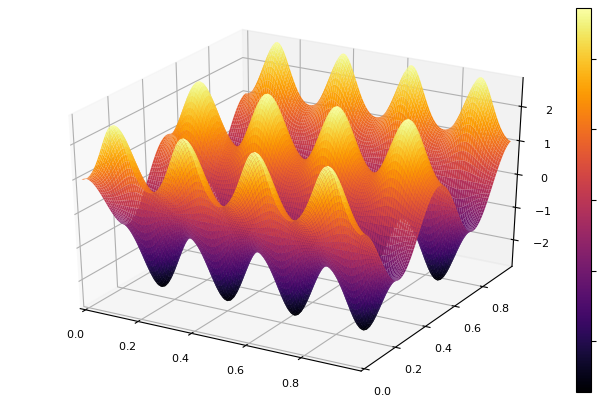

In [13]:
plot(XX,YY,u(XX,YY),st=:surface)

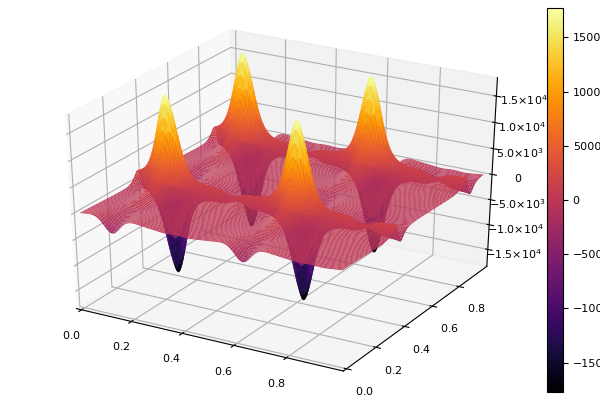

In [14]:
plot(XX,YY,f.(XX,YY,ϵ1),st=:surface)

In [15]:
DA1 = NSF2D.get_stagger_grids(6,n,a1(xxh))
DB1 = NSF2D.get_stagger_grids(6,n,b1(yyh))
AA1 = Array(Diagonal(a1(xx)))
BB1 = Array(Diagonal(b1(yy)))

DA2 = NSF2D.get_stagger_grids(2,n,a2(xxh))
DB2 = NSF2D.get_stagger_grids(2,n,b2(yyh))
AA2 = Array(Diagonal(a2(yy)))
BB2 = Array(Diagonal(b2(yy)))

DA3 = NSF2D.get_stagger_grids(2,n,a3(xxh))
DB3 = NSF2D.get_stagger_grids(2,n,b3(yyh))
AA3 = Array(Diagonal(a3(yy)))
BB3 = Array(Diagonal(b3(yy)))
;

In [16]:
X = CanTenDec(n,2,2,[1,1],
    [BB1,DB1],
    [DA1,AA1])
NSF2D.normalize(X,atol)

# X = CanTenDec(n,4,4,[1,1,1,1],
#     [BB1,DB1,BB2,DB2],
#     [DA1,AA1,DA2,AA2])
# NSF2D.normalize(X,atol)

Get preconditioner

In [17]:
P = CanTenDec(n,1,1,[1.],
    [spdiagm(0=>b1(xx))],
    [spdiagm(0=>a1(yy))])

# P = CanTenDec(n,2,2,[1.,1.],
#     [spdiagm(0=>b1(xx)),spdiagm(0=>b2(xx))],
#     [spdiagm(0=>a1(yy)),spdiagm(0=>a2(xx))])
NSF2D.normalize(P,atol)

Q = invsqrt(P,1e-2)
;

atol2 0.01
X0 rank 2
err 20.89301905119387
atol2 0.001
X0 rank 3
err 20.760107521093715
atol2 0.001
X0 rank 4
err 20.464400335211323
atol2 0.001
X0 rank 5
err 19.814974669829407
atol2 0.001
X0 rank 6
err 18.432096420816137
atol2 0.001
X0 rank 7
err 15.685994192027014
atol2 0.001
truncating svals 0.004218585496520379 0.004572021663193183
X0 rank 4
err 10.965240179614225
atol2 0.001
X0 rank 3
err 5.072850504366821
atol2 0.001
X0 rank 2
err 0.972064091593392
atol2 0.001
X0 rank 1
err 0.016148541292949403
atol2 0.001
X0 rank 1
err 0.004085558470389827


In [18]:
Q.rank

1

In [19]:
norm(sum(Q.sig[j]*kron(diag(Q.u[j]),diag(Q.v[j])) for j in 1:Q.rank).^2.0.*sum(P.sig[j]*kron(diag(P.u[j]),diag(P.v[j])) for j in 1:P.rank)-ones(n^2),Inf)

0.00019455040335170093

In [20]:
ff = f.(XX,YY,ϵ1)
uu = u(XX,YY)
;

Test using sparse data structure

In [21]:
Y = NSF2D.mul(NSF2D.mul(Q,X,atol/1e2),Q,atol/1e2)
NSF2D.reduce(Y,atol/1e2)
println(Y.rank)

2


In [22]:
Random.seed!(1234)
atol = 1e-5
@time Y_nsf = NSF2D.get_NSFMatrix(Y,m,scales,atol)
@time Y_fac = NSF2D.get_NSFMatrix_decomp(Y,m,scales,atol)
;

atol2 = 1.0000000000000002e-6
atol2 = 6.250000000000001e-8
  0.187765 seconds (441.17 k allocations: 180.045 MiB, 28.22% gc time)
construct decomposition of scale 1
rank of T is 2
getting NSFMatCoefs 
atol2 = 1.0000000000000002e-6
  0.122461 seconds (328.85 k allocations: 137.880 MiB, 27.68% gc time)
done
compute factorization
atol2 = 0.1
invMatA err is 0.7885013735535015
err reduction is 0.21149862644649853
atol2 = 0.039425068677675076
invMatA err is 0.6265450714328649
err reduction is 0.20539761572101756
atol2 = 0.019712534338837538
invMatA err is 0.43085907629280695
err reduction is 0.3123254879214638
atol2 = 0.009856267169418769
invMatA err is 0.25019989616662686
err reduction is 0.4192999290640594
atol2 = 0.0049281335847093845
invMatA err is 0.09855695491060201
err reduction is 0.6060871470347632
atol2 = 0.0049281335847093845
invMatA err is 0.02564071071534857
err reduction is 0.7398386472207216
atol2 = 0.002564071071534857
invMatA err is 0.0037718750024150483
err reduction is 0.8

In [23]:
@time rhs = NSF2D.NSFVector_decomp(n,m,scales,NSF2D.apply(Q,hh*hh*ff))
;

  0.011860 seconds (86.74 k allocations: 4.124 MiB)


In [24]:
@time sol = NSF2D.apply(Q,NSF2D.NSFVector_reconst(NSF2D.fbsub(Y_fac,rhs,atol/1e2)))
;

fbsub using atol = 1.0000000000000001e-7
forward sub....
backward sub....
  1.626833 seconds (70.22 k allocations: 265.751 MiB, 3.64% gc time)


In [25]:
sol .-= (sol[1,1]-1)
;

In [26]:
println("abs err: ",maximum(abs.(sol.-uu)))
println("l2 err: ",sqrt(sum((sol.-uu).^2))/n)

for i in 1:scales
    display(NSF2D.get_rank(Y_fac.coefs[i]))
end

abs err: 0.0009386975946750198
l2 err: 

4×4 Array{Int64,2}:
 4  3  3  6
 3  4  2  7
 3  2  4  6
 2  2  2  4

4×4 Array{Int64,2}:
 7  6  6  16
 6  6  6  15
 6  6  7  15
 4  4  4   4

0.0005282648972526066


In [26]:
println("abs err: ",maximum(abs.(sol.-uu)))
println("l2 err: ",sqrt(sum((sol.-uu).^2))/n)

for i in 1:scales
    display(NSF2D.get_rank(Y_fac.coefs[i]))
end

abs err: 0.0535454397490116
l2 err: 

4×4 Array{Int64,2}:
 4  3  3  6
 3  4  2  7
 3  2  4  6
 2  2  2  4

4×4 Array{Int64,2}:
 8  7  8  13
 7  7  6  13
 7  6  7   8
 4  4  4   4

0.028474008684014673


In [67]:
println("abs err: ",maximum(abs.(sol.-uu)))
println("l2 err: ",sqrt(sum((sol.-uu).^2))/n)

for i in 1:scales
    display(NSF2D.get_rank(Y_fac.coefs[i]))
end

4×4 Array{Int64,2}:
 4  4  4  8
 4  5  3  8
 4  3  5  8
 2  2  2  4

abs err: 0.0003411468182337174
l2 err: 0.00010832471232708852


In [47]:
s = Y_fac.coefs[1].A.values[1,1].sig[1:Y_fac.coefs[1].A.values[1,1].rank]

4-element Array{Float64,1}:
 0.11562347362806333
 0.0030505684518566914
 2.6868155298565865e-5
 6.4596480831270854e-6

In [49]:
s = Y_fac.coefs[2].A.values[1,1].sig[1:Y_fac.coefs[1].A.values[1,1].rank]

4-element Array{Float64,1}:
 0.3887587453798729
 0.017915714730719904
 0.00046514137086921064
 3.2458011775546196e-5

In [81]:
for i in sortperm(s,rev=true)
    println(s[i])
end

0.004777680205880605
5.5751742252821064e-5
3.319494449505302e-6
2.5016336750962335e-7
1.2320123090412938e-7
1.4838990729842511e-8
1.2968866924040501e-8
3.0313979354644455e-9


In [76]:
println("abs err: ",maximum(abs.(sol.-uu)))
println("l2 err: ",sqrt(sum((sol.-uu).^2))/n)

for i in 1:scales
    display(NSF2D.get_rank(Y_fac.coefs[i]))
end

4×4 Array{Int64,2}:
 2  1  1  5
 1  2  0  7
 1  0  2  7
 2  2  2  8

4×4 Array{Int64,2}:
 2  1  1   9
 1  3  1   9
 1  1  3   9
 5  5  5  10

4×4 Array{Int64,2}:
 3  2  2  13
 2  3  1  13
 2  1  3  14
 7  6  6  11

abs err: 0.0005299701746932506
l2 err: 0.00019717772448906158


# Scratch

In [241]:
Y_dense = to_dense(Y)
Q_dense = to_dense(Q)
;

In [242]:
F = svd(Y_dense)
;

In [243]:
S = 1.0./F.S
S[length(S)] = 0
INV = F.V*diagm(S)*F.U'
;

In [244]:
sol = reshape(Q_dense*INV*Q_dense*reshape(hh*hh*ff,n^2,1),n,n)
sol .-= (sol[1,1]-1.0)
;

In [245]:
println("abs err: ",maximum(abs.(sol.-uu)))
println("l2 err: ",sqrt(sum((sol.-uu).^2))/n)
# plot(XX,YY,uu-sol,st=:surface)
# plot(XX,YY,sol,st=:surface)

abs err: 0.08406417856453519
l2 err: 0.05289267029612175


In [35]:
m = 8
scales = 4
;

In [36]:
@time rhs = NSF2D.NSFVector_decomp(n,m,scales,NSF2D.apply(Q,hh*hh*ff))
;

  0.081044 seconds (354.98 k allocations: 16.613 MiB, 32.49% gc time)


In [37]:
# @time Y_nsf = NSF2D.get_NSFMatrix(Y,m,scales,1e-10)
@time Y_fac = NSF2D.get_NSFMatrix_decomp(Y,m,scales,1e-6)
;

construct decomposition of scale 1
rank of T is 2
getting NSFMatCoefs 
atol2 = 1.0e-7
  0.370607 seconds (1.17 M allocations: 540.186 MiB, 7.16% gc time)
done
compute factorization
atol2 = 0.1
invMatA err is 0.7872471142856249
err reduction is 0.21275288571437512
atol2 = 0.03936235571428125
invMatA err is 0.6241001389218455
err reduction is 0.2072373113896068
atol2 = 0.019681177857140623
invMatA err is 0.4272204954260812
err reduction is 0.3154616242128717
atol2 = 0.009840588928570312
invMatA err is 0.24735738850066835
err reduction is 0.42100767367452585
atol2 = 0.004920294464285156
invMatA err is 0.09709459447182656
err reduction is 0.607472430638294
atol2 = 0.004920294464285156
invMatA err is 0.0246120214972535
err reduction is 0.7465150183577414
atol2 = 0.00246120214972535
invMatA err is 0.0036200072111626236
err reduction is 0.8529171116006629
atol2 = 0.00036200072111626237
invMatA err is 0.0006511270181009943
err reduction is 0.8201310162882591
atol2 = 4.239663937010925e-7
invMat

In [38]:
# @time Y_nsf2 = NSF2D.get_NSFMatrix(Y,m,scales,1e-4)
@time Y_fac2 = NSF2D.get_NSFMatrix_decomp(Y,m,scales,1e-3)
;

construct decomposition of scale 1
rank of T is 2
getting NSFMatCoefs 
atol2 = 0.0001
  0.452823 seconds (1.17 M allocations: 540.186 MiB, 7.53% gc time)
done
compute factorization
atol2 = 0.1
invMatA err is 0.7872481514538798
err reduction is 0.21275184854612017
atol2 = 0.03936240757269399
invMatA err is 0.6241019714300232
err reduction is 0.2072360280841058
atol2 = 0.019681203786346996
invMatA err is 0.4272224150030416
err reduction is 0.3154605584338497
atol2 = 0.009840601893173498
invMatA err is 0.24735867700212189
err reduction is 0.4210072591805352
atol2 = 0.004920300946586749
invMatA err is 0.09709539336541928
err reduction is 0.6074712456333748
atol2 = 0.004920300946586749
invMatA err is 0.0246122742209971
err reduction is 0.7465145011734119
atol2 = 0.00246122742209971
invMatA err is 0.003620050453588486
err reduction is 0.8529168649315565
atol2 = 0.0003620050453588486
invMatA err is 0.0006511312036558969
reach asked error threshold 0.001, return
  3.617184 seconds (1.05 M allo

In [80]:
# Y_fac2.coefs[1].T = Y_fac.coefs[1].T
# ;

In [81]:
# Y_fac2.coefs[scales].T = Y_fac.coefs[scales].T
# ;

In [39]:
sol = NSF2D.apply(Q,NSF2D.NSFVector_reconst(NSF2D.fbsub(Y_fac,rhs,atol/1e2)))
sol .-= (sol[1,1]-1)

println("abs err: ",maximum(abs.(sol.-uu)))
println("l2 err: ",sqrt(sum((sol.-uu).^2))/n)

for i in 1:scales
    display(NSF2D.get_rank(Y_fac.coefs[i]))
end
;

fbsub using atol = 1.0e-6
forward sub....
backward sub....


4×4 Array{Int64,2}:
 6  4  4  3
 4  6  3  4
 4  3  6  4
 2  2  2  6

4×4 Array{Int64,2}:
 7  6  6  3
 6  6  5  4
 6  5  6  5
 6  6  6  5

4×4 Array{Int64,2}:
 13  11  12  5
 11  10  10  5
 12  10  11  5
  5   5   5  4

4×4 Array{Int64,2}:
 26  24  25  8
 25  21  22  7
 26  23  23  7
  4   4   4  4

abs err: 0.07415772957597289
l2 err: 0.036414690588124875


In [1]:
sol = NSF2D.apply(Q,NSF2D.NSFVector_reconst(NSF2D.fbsub(Y_fac,rhs,atol/1e2)))
sol .-= (sol[1,1]-1)

println("abs err: ",maximum(abs.(sol.-uu)))
println("l2 err: ",sqrt(sum((sol.-uu).^2))/n)

for i in 1:scales
    display(NSF2D.get_rank(Y_fac.coefs[i]))
end
;

UndefVarError: UndefVarError: NSF2D not defined

In [22]:
sol = NSF2D.apply(Q,NSF2D.NSFVector_reconst(NSF2D.fbsub(Y_fac,rhs,atol/1e2)))
sol .-= (sol[1,1]-1)

println("abs err: ",maximum(abs.(sol.-uu)))
println("l2 err: ",sqrt(sum((sol.-uu).^2))/n)

for i in 1:scales
    display(NSF2D.get_rank(Y_fac.coefs[i]))
end
;

fbsub using atol = 1.0e-6
forward sub....
backward sub....
abs err: 0.0022805620550867545
l2 err: 

4×4 Array{Int64,2}:
 6  4  6  3
 5  6  4  4
 5  4  6  5
 2  2  2  6

4×4 Array{Int64,2}:
 14  13  13  7
 12  11  12  7
 15  12  12  7
  6   6   6  6

4×4 Array{Int64,2}:
 40  37  38  16
 37  33  34  14
 37  34  36  15
  6   6   6   9

0.0011345987206639414


In [82]:
sol = NSF2D.apply(Q,NSF2D.NSFVector_reconst(NSF2D.fbsub(Y_fac,rhs,atol/1e2)))
sol .-= (sol[1,1]-1)

println("abs err: ",maximum(abs.(sol.-uu)))
println("l2 err: ",sqrt(sum((sol.-uu).^2))/n)

for i in 1:scales
    display(NSF2D.get_rank(Y_fac.coefs[i]))
end
;

fbsub using atol = 1.0e-6
forward sub....


4×4 Array{Int64,2}:
 6  4  6  3
 5  6  4  4
 5  4  6  5
 2  2  2  6

4×4 Array{Int64,2}:
 16  13  15  8
 15  12  12  8
 16  12  14  7
  6   6   6  8

4×4 Array{Int64,2}:
 55  47  50  19
 47  43  45  19
 51  44  46  18
  8   8   8  11

backward sub....
abs err: 0.0024883554993264667
l2 err: 0.0012117565943344894


In [83]:
sol2 = NSF2D.apply(Q,NSF2D.NSFVector_reconst(NSF2D.fbsub(Y_fac2,rhs,atol)))
sol2 .-= (sol2[1,1]-1)

println("abs err: ",maximum(abs.(sol2.-uu)))
println("l2 err: ",sqrt(sum((sol2.-uu).^2))/n)

for i in 1:scales
    display(NSF2D.get_rank(Y_fac2.coefs[i]))
end
;

fbsub using atol = 0.0001
forward sub....


4×4 Array{Int64,2}:
 2  1  1  1
 1  2  1  2
 1  1  2  2
 2  2  2  2

4×4 Array{Int64,2}:
 5  4  5  2
 5  5  3  3
 5  4  5  3
 2  2  2  4

4×4 Array{Int64,2}:
 17  15  17  7
 16  14  15  5
 16  15  16  7
  4   4   4  4

backward sub....
abs err: 6.2126127585588495
l2 err: 2.9268089387238976


In [34]:
function schulz(A::Matrix{Float64},atol::Float64;maxiter=50)::Matrix{Float64}
    α = 1/maximum(abs.(eigvals(A'*A)))
    println(α)
    G0 = α*A
    for iter in 1:maxiter
        err = max(maximum(abs.(diag(G0*A).-1.0)),maximum(abs.(diag(A*G0).-1.0)))
        println(err)
        if  err < atol
            break
        else
            G0 = 2*G0-G0*A*G0
        end
    end
    return G0
end


function invMatA(A::NSF2D.MatA,atol::Float64;max_iter=50)::Union{Nothing,NSF2D.MatA}
    # Select α
    # atol2 = min(1e-3,atol*1e2)
    atol2 = 1e-4
    α = 1/NSF2D.snorm(A,atol2)
    
    println(α)

    # Initialize 
    G0 = copy(A)
    for i in 1:3, j in 1:3
        NSF2D.scale(G0.values[i,j],α)
    end 

    atol2 = 1e-1
    err = 1.0

    # Main iteration
    for _ in 1:max_iter
        
        println("atol2 = $(atol2)")

        # Check for termination
        # err_ = maximum(norm(diagvec(GA.values[j,j]).-1.0,Inf) for j in 1:3)
        err_ = max(maximum([norm(sum(NSF2D.diagmul(G0.values[i,j],A.values[j,i]) for j in 1:3).-1.0,Inf) for i in 1:3]),
            maximum([norm(sum(NSF2D.diagmul(A.values[i,j],G0.values[j,i]) for j in 1:3).-1.0,Inf) for i in 1:3]))
        # err_ = opnorm(to_dense(GA)-Matrix(1.0I,3*A.size^2,3*A.size^2),2)
        
        println("invMatA err is $(err_)")
        
        if err_ < atol
            println("reach asked error threshold $(atol), return")
            return G0
        end
            
        println("err reduction is $(abs(err_-err)/err)")
        atol2 = min(atol2,err_/10)
        if err_ >= err || abs(err_-err) <= 0.5*err
            atol2 /= 2
        end
        if err_ < 1e-3
            atol2 = max(err*err,atol/1e2)
        end
        err = err_
        
        # 
        B = NSF2D.mul(NSF2D.mul(G0,A,atol2),G0,atol2)

        for i in 1:3, j in 1:3
            NSF2D.scale(G0.values[i,j],2.0)
        end

        for i in 1:3, j in 1:3
            NSF2D.axpy(-1.0,B.values[i,j],G0.values[i,j],atol2)
            NSF2D.reduce(G0.values[i,j],atol2)
        end
    end

    # No convergence
    @warn("invMatA maximum number of iteration reached")
end

invMatA (generic function with 1 method)

In [27]:
function get_NSFMatrix_decomp(n::Int,
        X::Matrix{Float64},
        moments::Int,
        scales::Int,
        )
    if size(X) != (n*n,n*n)
        throw("Expected a matrix of size $(n*n)-by-$(n*n), got $(size(X))")
    end
    
    if n%2^scales != 0
        throw("Invalid number of scales")
    end
    
    H,G = NSF2D.get_qmf(moments)
    Y = Dict()
    
    Z = copy(X)
    for j in 1:scales
        A,B,C,T = dwtd2d(n,Z,moments,H,G)
        Ainv = inv(A)
        Y[j] = (Ainv,B,Ainv*C,T-B*Ainv*C)
        Z = copy(Y[j][4])
        n ÷= 2
    end
    
    return Y
end

get_NSFMatrix_decomp (generic function with 1 method)

In [28]:
function dwtd2d(n::Int,
    X::Matrix{Float64},
    m::Int,
    H::Vector{Float64},
    G::Vector{Float64},
    )
    
    if size(X) != (n*n,n*n)
        throw("Expected a matrix of size $(n*n)-by-$(n*n), got $(size(X))")
    end
    
    # Transform rows
    for i in 1:n*n
        for j in 1:n
            d,s = NSF2D.dwtvec(n,X[i,(j-1)*n+1:j*n],m,H,G)
            X[i,(j-1)*n+1:(j-1)*n+n÷2] = d
            X[i,(j-1)*n+n÷2+1:j*n] = s
        end
    end
    
    for i in 1:n*n
        for j in 1:n
            d,s = NSF2D.dwtvec(n,X[i,j:n:(n-1)*n+j],m,H,G)
            X[i,j:n:(n÷2-1)*n+j] = d
            X[i,(n÷2)*n+j:n:(n-1)*n+j] = s
        end
    end
    
    # Transform columns
    for i in 1:n*n
        for j in 1:n
            d,s = NSF2D.dwtvec(n,X[(j-1)*n+1:j*n,i],m,H,G)
            X[(j-1)*n+1:(j-1)*n+n÷2,i] = d
            X[(j-1)*n+n÷2+1:j*n,i] = s
        end
    end
    
    for i in 1:n*n
        for j in 1:n            
            d,s = NSF2D.dwtvec(n,X[j:n:(n-1)*n+j,i],m,H,G)
            X[j:n:(n÷2-1)*n+j,i] = d
            X[(n÷2)*n+j:n:(n-1)*n+j,i] = s
        end
    end
    
    index = reshape([i for i in 1:n*n],(n,n))
    new_index = vcat(collect(Iterators.flatten(index[1:n÷2,1:n÷2])),
        collect(Iterators.flatten(index[n÷2+1:n,1:n÷2])),
        collect(Iterators.flatten(index[1:n÷2,n÷2+1:n])),
        collect(Iterators.flatten(index[n÷2+1:n,n÷2+1:n]))
    )
    
    X = X[new_index,new_index]
    
    k = n*n÷4
    return X[1:3*k,1:3*k],X[3*k+1:4*k,1:3*k],X[1:3*k,3*k+1:4*k],X[3*k+1:4*k,3*k+1:4*k]
    
end

dwtd2d (generic function with 1 method)

In [28]:
n = 64
m = 8
scales = 3
H,G = NSF2D.get_qmf(8)
Yd = to_dense(Y)
Y_fac3 = get_NSFMatrix_decomp(n,Yd,m,scales)
;

OutOfMemoryError: OutOfMemoryError()

In [30]:
for j in 1:scales
    println("scale $(j)")
    println("$(opnorm(Y_fac3[j][1]-to_dense(Y_fac.coefs[j].A)))")
    println("$(opnorm(Y_fac3[j][4]-to_dense(Y_fac.coefs[j].T)))")
    println("$(opnorm(Y_fac3[j][1]-to_dense(Y_fac2.coefs[j].A)))")
    println("$(opnorm(Y_fac3[j][4]-to_dense(Y_fac2.coefs[j].T)))")
end

scale 1
1.5678993188865636e-7
1.5330671557031878e-5
3.427121717819089e-5
0.00026318061959749
scale 2
3.2491048602393264e-6
1.46794349616173e-6
0.00016018586418274725
5.018506909378501e-5
scale 3
1.554861096503763e-5
9.800468090922402e-7
0.0004518379143764758
2.300463783686951e-5


In [31]:
j = scales
println("$(opnorm(invsigmat(Y_fac3[j][4])-invsigmat(to_dense(Y_fac.coefs[j].T))))")
println("$(opnorm(invsigmat(Y_fac3[j][4])-invsigmat(to_dense(Y_fac2.coefs[j].T))))")

0.24947550932530663
4.308408780357705


In [57]:
exp(1)

2.718281828459045

In [61]:
pi

π = 3.1415926535897...